# Bengali.AI fastai2 starter
I decided to start working with fastai2, after a few hours of searching the notebooks and documentation I finnaly got to this point. I figured this may be helpfull to other people wanting to learn about the new fastai version so I'm sharing this notebook. Let me know if you find anything that can be improved, I'm just getting started with fastai2!

Some references:
* https://www.kaggle.com/yiheng/iterative-stratification
* https://www.kaggle.com/iafoss/image-preprocessing-128x128
* https://www.kaggle.com/iafoss/grapheme-fast-ai-starter-lb-0-964
* https://github.com/fastai/fastai2
* http://dev.fast.ai/

Versions log:
* **Version 4:** fastai2 starter code; LB0.9598
* **Version 5:** Updated to fastai2 v0.07; Added MixUp

In [1]:
# Clone and install fastai2
#!git clone https://github.com/fastai/fastai2 lib
#!pip install -e lib
#!ln -s lib/fastai2 fastai2
!pip install scikit-learn fastai2 --upgrade

  Using cached https://files.pythonhosted.org/packages/3f/1b/48e49571f156fda9a870b6bb6f18941885eff1982bbdc892c740e4d02f63/fastai2-0.0.7-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/62/01/9cab1fdaef504edbe2e203111fd9d5d68fdc55ca06621e84851caa8ba7cf/fastcore-0.1.10-py3-none-any.whl
  Found existing installation: scikit-learn 0.21.3
    Uninstalling scikit-learn-0.21.3:
      Successfully uninstalled scikit-learn-0.21.3


ERROR: Could not install packages due to an EnvironmentError: [WinError 5] Access is denied: 'c:\\users\\channo.oocldm\\appdata\\local\\continuum\\anaconda3\\lib\\site-packages\\~klearn\\metrics\\cluster\\expected_mutual_info_fast.cp37-win_amd64.pyd'
Consider using the `--user` option or check the permissions.



In [4]:
import fastai2
from fastai2.vision.all import *
from sklearn.metrics import recall_score
print(fastai2.__version__)

0.0.7


In [7]:
# Configs
sz = 128
bs = 128
nfolds = 5
fold = 0
TRAIN = Path('../data/grapheme-imgs-128x128')
LABELS = Path('../data/iterative-stratification/train_with_fold.csv')
arch = xresnet50

In [8]:
# Load dataframe
df = pd.read_csv(LABELS)
df.head()

,image_id,grapheme_root,vowel_diacritic,consonant_diacritic,grapheme,id,fold
0,Train_0,15,9,5,ক্ট্রো,0,3
1,Train_1,159,0,0,হ,1,2
2,Train_2,22,3,5,খ্রী,2,4
3,Train_3,53,2,2,র্টি,3,2
4,Train_4,71,9,5,থ্রো,4,1


In [ ]:
# Create databunch
bengali = DataBlock(blocks=(ImageBlock(cls=PILImageBW), *(3*[CategoryBlock])),
                    getters=[ColReader('image_id', pref=TRAIN, suff='.png'),   # input
                             ColReader('grapheme_root'),                       # label 1
                             ColReader('vowel_diacritic'),                     # label 2
                             ColReader('consonant_diacritic')],                # label 3
                    splitter=IndexSplitter(df.loc[df.fold==fold].index))

tfms = aug_transforms(do_flip=False, size=sz)
tfms += [Normalize.from_stats([0.0692], [0.2051])]
dls = bengali.dataloaders(df, bs=bs, batch_tfms=tfms)
dls.n_inp = 1 # number of inputs

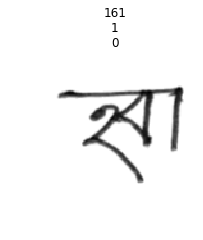

In [6]:
# Show an example
dls.show_batch(max_n=1, figsize=(3,3))

In [7]:
# Model 
class Head(Module):
    def __init__(self, nc, n, ps=0.5):
        self.fc = nn.Sequential(*[AdaptiveConcatPool2d(), nn.ReLU(inplace=True), Flatten(),
             LinBnDrop(nc*2, 512, True, ps, nn.ReLU(inplace=True)),
             LinBnDrop(512, n, True, ps)])
        self._init_weight()
        
    def _init_weight(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                torch.nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1.0)
                m.bias.data.zero_()
        
    def forward(self, x):
        return self.fc(x)

class BengaliModel(Module):
    def __init__(self, arch=arch, n=dls.c, pre=True):
        m = arch(pre)
        m = nn.Sequential(*children_and_parameters(m)[:-4])
        conv = nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1, bias=False)
        w = (m[0][0].weight.sum(1)).unsqueeze(1)
        conv.weight = nn.Parameter(w)
        m[0][0] = conv
        nc = m(torch.zeros(2, 1, sz, sz)).detach().shape[1]
        self.body = m
        self.heads = nn.ModuleList([Head(nc, c) for c in n])
        
    def forward(self, x):    
        x = self.body(x)
        return [f(x) for f in self.heads]

In [8]:
# Loss function
class Loss_combine(Module):
    def __init__(self, func=F.cross_entropy, weights=[2, 1, 1]):
        self.func, self.w = func, weights

    def forward(self, xs, *ys, reduction='mean'):
        for i, w, x, y in zip(range(len(xs)), self.w, xs, ys):
            if i == 0: loss = w*self.func(x, y, reduction=reduction) 
            else: loss += w*self.func(x, y, reduction=reduction) 
        return loss

In [9]:
# Metrics
class RecallPartial(Metric):
    # based on AccumMetric
    "Stores predictions and targets on CPU in accumulate to perform final calculations with `func`."
    def __init__(self, a=0, **kwargs):
        self.func = partial(recall_score, average='macro', zero_division=0)
        self.a = a

    def reset(self): self.targs,self.preds = [],[]

    def accumulate(self, learn):
        pred = learn.pred[self.a].argmax(dim=-1)
        targ = learn.y[self.a]
        pred,targ = to_detach(pred),to_detach(targ)
        pred,targ = flatten_check(pred,targ)
        self.preds.append(pred)
        self.targs.append(targ)

    @property
    def value(self):
        if len(self.preds) == 0: return
        preds,targs = torch.cat(self.preds),torch.cat(self.targs)
        return self.func(targs, preds)

    @property
    def name(self): return df.columns[self.a+1]
    
class RecallCombine(Metric):
    def accumulate(self, learn):
        scores = [learn.metrics[i].value for i in range(3)]
        self.combine = np.average(scores, weights=[2,1,1])

    @property
    def value(self):
        return self.combine

In [10]:
# MixUp
from torch.distributions.beta import Beta
def NoLoss(*o): pass
class MixUp(Callback):
    run_after,run_valid = [Normalize],False
    def __init__(self, alpha=0.4): 
        self.distrib = Beta(tensor(alpha), tensor(alpha))
        
    def begin_fit(self):
        self.loss_func0 = self.learn.loss_func
        
    def begin_batch(self):
        self.learn.loss_func = NoLoss
        lam = self.distrib.sample((self.y[0].size(0),)).squeeze().to(self.x[0].device)
        lam = torch.stack([lam, 1-lam], 1)
        self.lam = lam.max(1)[0]
        shuffle = torch.randperm(self.y[0].size(0)).to(self.x.device)
        xb1 = tuple(L(self.xb).itemgot(shuffle))
        yb1 = tuple([self.yb[i][shuffle] for i in range(len(self.yb))])
        nx_dims = len(self.x.size())
        self.learn.xb = tuple(L(xb1,self.xb).map_zip(torch.lerp,weight=unsqueeze(self.lam, n=nx_dims-1)))
        self.learn.yb = yb1,self.yb
        
    def after_loss(self):
        loss0 = self.loss_func0(self.learn.pred, *self.learn.yb[0], reduction='none')
        loss1 = self.loss_func0(self.learn.pred, *self.learn.yb[1], reduction='none')
        self.learn.loss = torch.lerp(loss0, loss1, self.lam).mean()
        self.learn.loss_func = self.loss_func0

In [11]:
# Create learner
learn = Learner(dls, BengaliModel(), loss_func=Loss_combine(), cbs=[MixUp(), CSVLogger()],
                metrics=[RecallPartial(a=i) for i in range(len(dls.c))] + [RecallCombine()],
                splitter=lambda m: [list(m.body.parameters()), list(m.heads.parameters())])

Downloading: "https://s3.amazonaws.com/fast-ai-modelzoo/xrn50_940.pth" to /root/.cache/torch/checkpoints/xrn50_940.pth
100%|██████████| 244M/244M [00:07<00:00, 32.1MB/s]


In [12]:
learn.fit_one_cycle(36, lr_max=slice(1e-3, 1e-2))

epoch,train_loss,valid_loss,grapheme_root,vowel_diacritic,consonant_diacritic,recall_combine,time
0,7.908321,5.326334,0.323778,0.746562,0.651101,0.511305,13:16
1,6.100447,2.944874,0.634519,0.861708,0.847244,0.744497,11:48
2,5.165979,2.208519,0.728883,0.890526,0.838163,0.796614,11:50
3,4.576111,1.702204,0.796836,0.893226,0.840672,0.831892,11:46
4,4.251759,1.203010,0.843110,0.951133,0.919258,0.889153,11:32
5,3.957603,1.193525,0.842582,0.949402,0.943439,0.894501,11:34
6,3.834054,1.015055,0.851454,0.959591,0.919157,0.895414,11:32
7,3.729827,0.874365,0.873359,0.956728,0.960677,0.916031,11:37
8,3.584240,0.780782,0.901509,0.970467,0.958262,0.932937,11:27
9,3.442394,0.713345,0.912944,0.974009,0.961768,0.940416,11:21


In [13]:
learn.save('model')

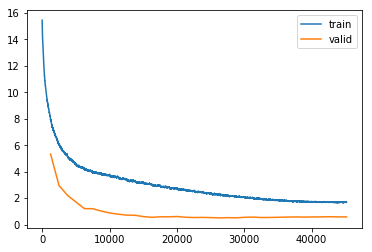

In [14]:
learn.recorder.plot_loss()